In [13]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import tweepy 
import seaborn as sns
import requests
import json
from timeit import default_timer as timer
%matplotlib inline

## Gather

In this part of the notebook, we will gather the data from the required 3 sources.

- __The WeRateDogs Twitter archive CSV file.__

In [14]:
archive = pd.read_csv("twitter-archive-enhanced.csv")

In [15]:
archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


__2. Downloading image_predictions.csv file using requests library__

In [16]:
 r = requests.get("https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv")

In [17]:
with open("image-predictions.tsv","w") as file:
    file.writelines(r.content.decode('utf-8'))

In [18]:
image_predictions = pd.read_csv("image-predictions.tsv",sep='\t')

In [19]:
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [20]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


__3. Using Tweepy library to fetch the tweets information in the archive df and dump the details into tweet_json.txt.__

In [25]:
consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

In [26]:
tweet_ids = archive.tweet_id.values
len(tweet_ids)

2356

In [27]:
archive.shape[0]

2356

In [28]:
count = 0
success_count = 0
fail_count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            success_count+=1
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fail_count+=1
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

1: 892420643555336193
Success
2: 892177421306343426
Success
3: 891815181378084864
Success
4: 891689557279858688
Success
5: 891327558926688256
Success
6: 891087950875897856
Success
7: 890971913173991426
Success
8: 890729181411237888
Success
9: 890609185150312448
Success
10: 890240255349198849
Success
11: 890006608113172480
Success
12: 889880896479866881
Success
13: 889665388333682689
Success
14: 889638837579907072
Success
15: 889531135344209921
Success
16: 889278841981685760
Success
17: 888917238123831296
Success
18: 888804989199671297
Success
19: 888554962724278272
Success
20: 888202515573088257
Fail
21: 888078434458587136
Success
22: 887705289381826560
Success
23: 887517139158093824
Success
24: 887473957103951883
Success
25: 887343217045368832
Success
26: 887101392804085760
Success
27: 886983233522544640
Success
28: 886736880519319552
Success
29: 886680336477933568
Success
30: 886366144734445568
Success
31: 886267009285017600
Success
32: 886258384151887873
Success
33: 8860541600590725

Fail
262: 842846295480000512
Success
263: 842765311967449089
Success
264: 842535590457499648
Success
265: 842163532590374912
Success
266: 842115215311396866
Success
267: 841833993020538882
Success
268: 841680585030541313
Success
269: 841439858740625411
Success
270: 841320156043304961
Success
271: 841314665196081154
Success
272: 841077006473256960
Success
273: 840761248237133825
Success
274: 840728873075638272
Success
275: 840698636975636481
Success
276: 840696689258311684
Success
277: 840632337062862849
Success
278: 840370681858686976
Success
279: 840268004936019968
Success
280: 839990271299457024
Success
281: 839549326359670784
Success
282: 839290600511926273
Success
283: 839239871831150596
Success
284: 838952994649550848
Success
285: 838921590096166913
Success
286: 838916489579200512
Success
287: 838831947270979586
Success
288: 838561493054533637
Success
289: 838476387338051585
Success
290: 838201503651401729
Success
291: 838150277551247360
Success
292: 838085839343206401
Success
293

Success
519: 810657578271330305
Success
520: 810284430598270976
Success
521: 810254108431155201
Success
522: 809920764300447744
Success
523: 809808892968534016
Success
524: 809448704142938112
Success
525: 809220051211603969
Success
526: 809084759137812480
Success
527: 808838249661788160
Success
528: 808733504066486276
Success
529: 808501579447930884
Success
530: 808344865868283904
Success
531: 808134635716833280
Success
532: 808106460588765185
Success
533: 808001312164028416
Success
534: 807621403335917568
Success
535: 807106840509214720
Success
536: 807059379405148160
Success
537: 807010152071229440
Success
538: 806629075125202948
Success
539: 806620845233815552
Success
540: 806576416489959424
Success
541: 806542213899489280
Success
542: 806242860592926720
Success
543: 806219024703037440
Success
544: 805958939288408065
Success
545: 805932879469572096
Success
546: 805826884734976000
Success
547: 805823200554876929
Success
548: 805520635690676224
Success
549: 805487436403003392
Success


Success
776: 776201521193218049
Success
777: 776113305656188928
Success
778: 776088319444877312
Success
779: 775898661951791106
Success
780: 775842724423557120
Success
781: 775733305207554048
Success
782: 775729183532220416
Success
783: 775364825476165632
Success
784: 775350846108426240
Success
785: 775096608509886464
Fail
786: 775085132600442880
Success
787: 774757898236878852
Success
788: 774639387460112384
Success
789: 774314403806253056
Success
790: 773985732834758656
Success
791: 773922284943896577
Success
792: 773704687002451968
Success
793: 773670353721753600
Success
794: 773547596996571136
Success
795: 773336787167145985
Success
796: 773308824254029826
Success
797: 773247561583001600
Success
798: 773191612633579521
Success
799: 772877495989305348
Success
800: 772826264096874500
Success
801: 772615324260794368
Success
802: 772581559778025472
Success
803: 772193107915964416
Success
804: 772152991789019136
Success
805: 772117678702071809
Success
806: 772114945936949249
Success
807

Success
1032: 745422732645535745
Success
1033: 745314880350101504
Success
1034: 745074613265149952
Success
1035: 745057283344719872
Success
1036: 744995568523612160
Success
1037: 744971049620602880
Success
1038: 744709971296780288
Success
1039: 744334592493166593
Success
1040: 744234799360020481
Success
1041: 744223424764059648
Success
1042: 743980027717509120
Success
1043: 743895849529389061
Success
1044: 743835915802583040
Success
1045: 743609206067040256
Success
1046: 743595368194129920
Success
1047: 743545585370791937
Success
1048: 743510151680958465
Success
1049: 743253157753532416
Success
1050: 743222593470234624
Success
1051: 743210557239623680
Success
1052: 742534281772302336
Success
1053: 742528092657332225
Success
1054: 742465774154047488
Success
1055: 742423170473463808
Success
1056: 742385895052087300
Success
1057: 742161199639494656
Success
1058: 742150209887731712
Success
1059: 741793263812808706
Success
1060: 741743634094141440
Success
1061: 741438259667034112
Success
10

Success
1281: 708834316713893888
Success
1282: 708810915978854401
Success
1283: 708738143638450176
Success
1284: 708711088997666817
Success
1285: 708479650088034305
Success
1286: 708469915515297792
Success
1287: 708400866336894977
Success
1288: 708356463048204288
Success
1289: 708349470027751425
Success
1290: 708149363256774660
Success
1291: 708130923141795840
Success
1292: 708119489313951744
Success
1293: 708109389455101952
Success
1294: 708026248782585858
Success
1295: 707995814724026368
Success
1296: 707983188426153984
Success
1297: 707969809498152960
Success
1298: 707776935007539200
Success
1299: 707741517457260545
Success
1300: 707738799544082433
Success
1301: 707693576495472641
Success
1302: 707629649552134146
Success
1303: 707610948723478529
Success
1304: 707420581654872064
Success
1305: 707411934438625280
Success
1306: 707387676719185920
Success
1307: 707377100785885184
Success
1308: 707315916783140866
Success
1309: 707297311098011648
Success
1310: 707059547140169728
Success
13

Success
1530: 690248561355657216
Success
1531: 690021994562220032
Success
1532: 690015576308211712
Success
1533: 690005060500217858
Success
1534: 689999384604450816
Success
1535: 689993469801164801
Success
1536: 689977555533848577
Success
1537: 689905486972461056
Success
1538: 689877686181715968
Success
1539: 689835978131935233
Success
1540: 689661964914655233
Success
1541: 689659372465688576
Success
1542: 689623661272240129
Success
1543: 689599056876867584
Success
1544: 689557536375177216
Success
1545: 689517482558820352
Success
1546: 689289219123089408
Success
1547: 689283819090870273
Success
1548: 689280876073582592
Success
1549: 689275259254616065
Success
1550: 689255633275777024
Success
1551: 689154315265683456
Success
1552: 689143371370250240
Success
1553: 688916208532455424
Success
1554: 688908934925697024
Success
1555: 688898160958271489
Success
1556: 688894073864884227
Success
1557: 688828561667567616
Success
1558: 688804835492233216
Success
1559: 688789766343622656
Success
15

Success
1779: 677895101218201600
Success
1780: 677716515794329600
Success
1781: 677700003327029250
Success
1782: 677698403548192770
Success
1783: 677687604918272002
Success
1784: 677673981332312066
Success
1785: 677662372920729601
Success
1786: 677644091929329666
Success
1787: 677573743309385728
Success
1788: 677565715327688705
Success
1789: 677557565589463040
Success
1790: 677547928504967168
Success
1791: 677530072887205888
Success
1792: 677335745548390400
Success
1793: 677334615166730240
Success
1794: 677331501395156992
Success
1795: 677328882937298944
Success
1796: 677314812125323265
Success
1797: 677301033169788928
Success
1798: 677269281705472000
Success
1799: 677228873407442944
Success
1800: 677187300187611136
Success
1801: 676975532580409345
Success
1802: 676957860086095872
Success
1803: 676949632774234114
Success
1804: 676948236477857792
Success
1805: 676946864479084545
Success
1806: 676942428000112642
Success
1807: 676936541936185344
Success
1808: 676916996760600576
Success
18

Success
2028: 671874878652489728
Success
2029: 671866342182637568
Success
2030: 671855973984772097
Success
2031: 671789708968640512
Success
2032: 671768281401958400
Success
2033: 671763349865160704
Success
2034: 671744970634719232
Success
2035: 671743150407421952
Success
2036: 671735591348891648
Success
2037: 671729906628341761
Success
2038: 671561002136281088
Success
2039: 671550332464455680
Success
2040: 671547767500775424
Success
2041: 671544874165002241
Success
2042: 671542985629241344
Success
2043: 671538301157904385
Success
2044: 671536543010570240
Success
2045: 671533943490011136
Success
2046: 671528761649688577
Success
2047: 671520732782923777
Success
2048: 671518598289059840
Success
2049: 671511350426865664
Success
2050: 671504605491109889
Success
2051: 671497587707535361
Success
2052: 671488513339211776
Success
2053: 671486386088865792
Success
2054: 671485057807351808
Success
2055: 671390180817915904
Success
2056: 671362598324076544
Success
2057: 671357843010908160
Success
20

Success
2277: 667443425659232256
Success
2278: 667437278097252352
Success
2279: 667435689202614272
Success
2280: 667405339315146752
Success
2281: 667393430834667520
Success
2282: 667369227918143488
Success
2283: 667211855547486208
Success
2284: 667200525029539841
Success
2285: 667192066997374976
Success
2286: 667188689915760640
Success
2287: 667182792070062081
Success
2288: 667177989038297088
Success
2289: 667176164155375616
Success
2290: 667174963120574464
Success
2291: 667171260800061440
Success
2292: 667165590075940865
Success
2293: 667160273090932737
Success
2294: 667152164079423490
Success
2295: 667138269671505920
Success
2296: 667119796878725120
Success
2297: 667090893657276420
Success
2298: 667073648344346624
Success
2299: 667070482143944705
Success
2300: 667065535570550784
Success
2301: 667062181243039745
Success
2302: 667044094246576128
Success
2303: 667012601033924608
Success
2304: 666996132027977728
Success
2305: 666983947667116034
Success
2306: 666837028449972224
Success
23

We were able to fetch the folloiwng number of tweets using tweepy. The rest of the tweets have been deleted based on the responses above.

In [29]:
success_count

2327

In [30]:
len(tweet_ids)

2356

We will load the JSON file into a Data Frame.

In [31]:
json_data = []
with open('tweet_json.txt') as f:
    for line in f:
        json_data.append(json.loads(line))

In [32]:
len(json_data)

2327

We will consider the following fields from the information fetched by the API:

- tweet_id.
- retweet_count.
- favorit_count.
- lang.


We will create a Dictionary to hold all the values for each columns by iterating through the records in the JSON file.

In [33]:
records = {"tweet_id":[],"full_text":[], "retweet_count":[], "favorite_count":[], "lang":[]}

In [34]:
for i in range(len(json_data)):
    records["tweet_id"].append(json_data[i]["id"])
    records["full_text"].append(json_data[i]["full_text"])
    records["retweet_count"].append(json_data[i]['retweet_count'])
    records["favorite_count"].append(json_data[i]['favorite_count'])
    records["lang"].append(json_data[i]["lang"])

Now, We will create a DataFrame using the the records dictionary.

In [35]:
api_records = pd.DataFrame(records)

In [36]:
api_records.head()

,tweet_id,full_text,retweet_count,favorite_count,lang
0,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,7212,34609,en
1,892177421306343426,This is Tilly. She's just checking pup on you....,5409,29999,en
2,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,3575,22580,en
3,891689557279858688,This is Darla. She commenced a snooze mid meal...,7433,37871,en
4,891327558926688256,This is Franklin. He would like you to stop ca...,7976,36161,en


In [37]:
api_records.tail()

,tweet_id,full_text,retweet_count,favorite_count,lang
2322,666049248165822465,Here we have a 1949 1st generation vulpix. Enj...,37,92,en
2323,666044226329800704,This is a purebred Piers Morgan. Loves to Netf...,119,253,en
2324,666033412701032449,Here is a very happy pup. Big fan of well-main...,38,103,en
2325,666029285002620928,This is a western brown Mitsubishi terrier. Up...,41,116,en
2326,666020888022790149,Here we have a Japanese Irish Setter. Lost eye...,437,2324,en


## Asses

In [38]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [40]:
archive[["text","name","doggo","floofer","pupper","puppo"]].sample(20)

,text,name,doggo,floofer,pupper,puppo
840,This is Rupert. You betrayed him with bath tim...,Rupert,None,None,None,None
1022,Here's a golden floofer helping with the groce...,None,None,floofer,None,None
1733,This is Rinna. She's melting. 10/10 get inside...,Rinna,None,None,pupper,None
929,This is Milo. He's currently plotting his reve...,Milo,None,None,None,None
1294,This is Farfle. He lost his back legs during t...,Farfle,None,None,None,None
1231,This is Lance. Lance doesn't give a shit. 10/1...,Lance,None,None,None,None
1311,This is Tucker. He's a Dasani Episcopalian. Go...,Tucker,None,None,None,None
1027,This is Arlen and Thumpelina. They are best pa...,Arlen,None,None,None,None
1569,Meet Trooper &amp; Maya. Trooper protects Maya...,Trooper,None,None,None,None
1251,Meet Milo and Amos. They are the best of pals....,Milo,None,None,None,None


In [41]:
archive[archive["in_reply_to_status_id"] >0].iloc[30]

tweet_id                                                     786051337297522688
in_reply_to_status_id                                      772743019447607296.0
in_reply_to_user_id                                        730505014150582272.0
timestamp                                             2016-10-12 03:50:17 +0000
source                        <a href="http://twitter.com/download/iphone" r...
text                                    13/10 for breakdancing puppo @shibbnbot
retweeted_status_id                                                         NaN
retweeted_status_user_id                                                    NaN
retweeted_status_timestamp                                                  NaN
expanded_urls                                                               NaN
rating_numerator                                                             13
rating_denominator                                                           10
name                                    

In [42]:
archive.iloc[1877].text

"C'mon guys. We've been over this. We only rate dogs. This is a cow. Please only submit dogs. Thank you...... 9/10 https://t.co/WjcELNEqN2"

In [43]:
archive.name.value_counts()

None       745
a           55
Charlie     12
Cooper      11
Oliver      11
          ... 
Marlee       1
Randall      1
Tuck         1
Dale         1
Poppy        1
Name: name, Length: 957, dtype: int64

In [44]:
archive[archive["name"]=="a"][["text","name"]]

,text,name
56,Here is a pupper approaching maximum borkdrive...,a
649,Here is a perfect example of someone who has t...,a
801,Guys this is getting so out of hand. We only r...,a
1002,This is a mighty rare blue-tailed hammer sherk...,a
1004,Viewer discretion is advised. This is a terrib...,a
1017,This is a carrot. We only rate dogs. Please on...,a
1049,This is a very rare Great Alaskan Bush Pupper....,a
1193,People please. This is a Deadly Mediterranean ...,a
1207,This is a taco. We only rate dogs. Please only...,a
1340,Here is a heartbreaking scene of an incredible...,a


In [45]:
archive.doggo.value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [46]:
archive.floofer.value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [47]:
archive.pupper.value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [48]:
archive.puppo.value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

In [49]:
archive.iloc[1500:1510]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1500,692158366030913536,NaN,NaN,2016-01-27 01:33:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Edgar. He's a Sassafras Puggleflash. N...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/692158366...,10,10,Edgar,None,None,None,None
1501,692142790915014657,6.920419e+17,4.196984e+09,2016-01-27 00:31:15 +0000,"<a href=""http://twitter.com/download/iphone"" r...",These are some pictures of Teddy that further ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/692142790...,13,10,None,None,None,None,None
1502,692041934689402880,NaN,NaN,2016-01-26 17:50:29 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",This is Teddy. His head is too heavy. 13/10 (v...,NaN,NaN,NaN,https://vine.co/v/iiI3wmqXYmA,13,10,Teddy,None,None,None,None
1503,692017291282812928,NaN,NaN,2016-01-26 16:12:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Kingsley Wellensworth III. He owns 7 r...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/692017291...,9,10,Kingsley,None,None,None,None
1504,691820333922455552,NaN,NaN,2016-01-26 03:09:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Brockly. He's an uber driver. Falls as...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/691820333...,8,10,Brockly,None,None,None,None
1505,691793053716221953,NaN,NaN,2016-01-26 01:21:31 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",We usually don't rate penguins but this one is...,NaN,NaN,NaN,https://vine.co/v/OTTVAKw6YlW,10,10,None,None,None,None,None
1506,691756958957883396,NaN,NaN,2016-01-25 22:58:05 +0000,"<a href=""http://twitter.com/download/iphone"" r...",THE BRITISH ARE COMING\nTHE BRITISH ARE COMING...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/691756958...,10,10,None,None,None,None,None
1507,691675652215414786,NaN,NaN,2016-01-25 17:35:00 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Richie and Plip. They are the best of ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/691675652...,10,10,Richie,None,None,None,None
1508,691483041324204033,NaN,NaN,2016-01-25 04:49:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When bae says they can't go out but you see th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/691483041...,5,10,None,None,None,None,None
1509,691459709405118465,NaN,NaN,2016-01-25 03:16:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Leo. He's a Fallopian Puffalope. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/691459709...,12,10,Leo,None,None,None,None


In [50]:
archive.retweeted_status_timestamp.sample(5)

710                           NaN
1000                          NaN
1980                          NaN
606     2016-09-02 18:03:10 +0000
46                            NaN
Name: retweeted_status_timestamp, dtype: object

In [51]:
archive.retweeted_status_id.sample(10)

1524   NaN
2037   NaN
856    NaN
449    NaN
1510   NaN
2060   NaN
999    NaN
1738   NaN
221    NaN
1729   NaN
Name: retweeted_status_id, dtype: float64

In [52]:
archive.retweeted_status_id.iloc[411]

8.222448165201551e+17

In [53]:
archive.retweeted_status_user_id.sample(5)

1298           NaN
786            NaN
333            NaN
32      19607400.0
1482           NaN
Name: retweeted_status_user_id, dtype: float64

In [54]:
archive[archive["text"].str.startswith("RT ")]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1242,711998809858043904,NaN,NaN,2016-03-21 19:31:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @twitter: @dog_rates Awesome Tweet! 12/10. ...,7.119983e+17,7.832140e+05,2016-03-21 19:29:52 +0000,https://twitter.com/twitter/status/71199827977...,12,10,None,None,None,None,None
1286,708400866336894977,NaN,NaN,2016-03-11 21:15:02 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",RT if you are as ready for summer as this pup ...,NaN,NaN,NaN,https://vine.co/v/iHFqnjKVbIQ,12,10,None,None,None,None,None
1860,675489971617296384,NaN,NaN,2015-12-12 01:38:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT until we find this dog. Clearly a cool dog ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/675489971...,10,10,None,None,None,None,None
2259,667550904950915073,NaN,NaN,2015-11-20 03:51:52 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",RT @dogratingrating: Exceptional talent. Origi...,6.675487e+17,4.296832e+09,2015-11-20 03:43:06 +0000,https://twitter.com/dogratingrating/status/667...,12,10,None,None,None,None,None


In [55]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [56]:
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


#### Quality
##### `archive` table
- records have some text which starts with RT which means they are retweets.
- records have some decimal rating_numerator in text but the rating_numerator field has only the number after the decimal point.
- timestamp column has a wrong datatype. It is currently object while it should be datetime
- retweeted_status_timestamp column has a wrong datatype. It should be a datetime.
- in_reply_to_status_id column has a wrong datatype. It is currently float while it should be int.
- retweeted_status_id column has a wrong datatype. It is currently float while it should be int.
- retweeted_status_user_id column has a wrong datatype. It is currently float while it should be int.
- in_reply_to_user_id column has a wrong datatype. It is currently float while it should be int.
- Dog name column has the value None instead of NaN if the name is not metioned in the tweet.
- doggo,floofer,pupper,puppo coulmn has the values None insetad of NaN for records that don't mention dog stage.
- in many records, the dog name is mentioned as 'a' while there was no dog name mentioned.
- tweet id 691675652215414786 has 2 dog names.
- tweet id 712085617388212225 has 2 dog names.
- tweet id 684225744407494656, the dog stage should be pupper

##### `image_predictions` table
- columns names are not meaningful.

#### Tidiness
##### `archive` table
- columns doggo, floofer,pupper and	puppo can be under one column called dog_stage.


##### `image_predictions` table
- Merging with the `archive` table

##### `api_records` table
- Merging with the `archive` table

## Clean

In [57]:
archive_clean = archive.copy()

`archive` : records have some text which starts with RT which means they are retweets.

##### Define

Remove tweets which starts with RT since we only need to keep the original ratings.

##### Code

In [58]:
archive_clean = archive_clean.drop(archive_clean[archive_clean["text"].str.startswith("RT ")].index)

##### Test

In [59]:
archive_clean[archive_clean["text"].str.startswith("RT ")]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


`archive` table

- records have some decimal rating_numerator in text but the rating_numerator field has only the number after the decimal point.

##### Define

Modify the rating_numerator column to float and modify the values 

##### Code

In [60]:
archive_clean.rating_numerator = archive_clean.rating_numerator.astype("float")

In [62]:
archive_clean[archive_clean.text.str.contains(r"(\d+\.\d*\/\d+)")][['text', 'rating_numerator']]

D:\Anaconda\lib\site-packages\pandas\core\strings\accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,text,rating_numerator
45,This is Bella. She hopes her smile made you sm...,5.0
695,"This is Logan, the Chow who lived. He solemnly...",75.0
763,This is Sophie. She's a Jubilant Bush Pupper. ...,27.0
1689,I've been told there's a slight possibility he...,5.0
1712,Here we have uncovered an entire battalion of ...,26.0


In [64]:
archive_clean.loc[45,"text"]

'This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948'

In [65]:
archive_clean.loc[695,"text"]

"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS"

In [66]:
archive_clean.loc[763,"text"]

"This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq"

In [67]:
archive_clean.loc[1689,"text"]

"I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace"

In [68]:
archive_clean.loc[1712,"text"]

'Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD'

In [69]:
archive_clean.loc[45,"rating_numerator"] = 13.5
archive_clean.loc[695,"rating_numerator"] = 9.75
archive_clean.loc[763,"rating_numerator"] = 11.27
archive_clean.loc[1689,"rating_numerator"] = 9.5
archive_clean.loc[1712,"rating_numerator"] = 11.26

##### Test

In [70]:
archive_clean.loc[[45,695,763,1689,1712],"rating_numerator"] 

45      13.50
695      9.75
763     11.27
1689     9.50
1712    11.26
Name: rating_numerator, dtype: float64

`archive` timestamp column has a wrong datatype. It is currently object while it should be datetime.

`archive` retweeted_status_timestamp column has a wrong datatype. It should be a datetime.

##### Define

Change the columns type to datetime 

##### Code

In [71]:
archive_clean.timestamp = pd.to_datetime(archive_clean.timestamp)
archive_clean.retweeted_status_timestamp = pd.to_datetime(archive_clean.retweeted_status_timestamp)

##### Test

In [72]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2173 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2173 non-null   int64              
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2173 non-null   datetime64[ns, UTC]
 4   source                      2173 non-null   object             
 5   text                        2173 non-null   object             
 6   retweeted_status_id         0 non-null      float64            
 7   retweeted_status_user_id    0 non-null      float64            
 8   retweeted_status_timestamp  0 non-null      datetime64[ns]     
 9   expanded_urls               2115 non-null   object             
 10  rating_numerator            2173 non-null   float64         

We will drop the retweet related columns retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp since they don't have any values

In [73]:
archive_clean.drop(["retweeted_status_id", "retweeted_status_user_id", "retweeted_status_timestamp"],axis=1, inplace=True)

In [74]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2173 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               2173 non-null   int64              
 1   in_reply_to_status_id  78 non-null     float64            
 2   in_reply_to_user_id    78 non-null     float64            
 3   timestamp              2173 non-null   datetime64[ns, UTC]
 4   source                 2173 non-null   object             
 5   text                   2173 non-null   object             
 6   expanded_urls          2115 non-null   object             
 7   rating_numerator       2173 non-null   float64            
 8   rating_denominator     2173 non-null   int64              
 9   name                   2173 non-null   object             
 10  doggo                  2173 non-null   object             
 11  floofer                2173 non-null   object           

`archive`:

- in_reply_to_status_id column has a wrong datatype. It is currently float while it should be int.
- in_reply_to_user_id column has a wrong datatype. It is currently float while it should be int.

##### Define

change the above columns type to int

##### Code

In [75]:
archive_clean.loc[archive_clean["in_reply_to_status_id"].isnull(),"in_reply_to_status_id"]=0

In [76]:
archive_clean.loc[archive_clean["in_reply_to_user_id"].isnull(),"in_reply_to_user_id"]=0

In [77]:
archive_clean.in_reply_to_status_id = archive_clean.in_reply_to_status_id.astype("int64")
archive_clean.in_reply_to_user_id = archive_clean.in_reply_to_user_id.astype("int64")

##### Test

In [78]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2173 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               2173 non-null   int64              
 1   in_reply_to_status_id  2173 non-null   int64              
 2   in_reply_to_user_id    2173 non-null   int64              
 3   timestamp              2173 non-null   datetime64[ns, UTC]
 4   source                 2173 non-null   object             
 5   text                   2173 non-null   object             
 6   expanded_urls          2115 non-null   object             
 7   rating_numerator       2173 non-null   float64            
 8   rating_denominator     2173 non-null   int64              
 9   name                   2173 non-null   object             
 10  doggo                  2173 non-null   object             
 11  floofer                2173 non-null   object           

In [79]:
archive_clean.in_reply_to_status_id.unique()

array([                 0, 886266357075128320, 881607037314052096,
       879553827334172672, 870726202742493184, 863425645568774144,
       667152164079423488, 857156678055342080, 855818117272018944,
       856286004109553664, 855861584463351808, 855858535607001088,
       850328818778820608, 848212111729840128, 847606175596138496,
       759099523532779520, 840698300298862592, 838145498691194880,
       838085539362402304, 835245984028504064, 832087547559997440,
       831903044224835584, 826598365270007808, 823326389336244224,
       821152592717697024, 813127251579564032, 811627233043480576,
       733109485275860992, 801854330672447488, 800857954417262592,
       797123751162839040, 772743019447607296, 766711819364888576,
       763865174553964544, 750180498832404480, 747648653817413632,
       746885919387574272, 691416866452082688, 738411919896285184,
       729113531270991872, 707980065892667392, 703255935813287936,
       704485744639909888, 703041949650034688, 696488710901260

In [80]:
archive_clean.in_reply_to_user_id.unique()

array([                 0,         2281181600,           47384430,
               3105440746,           16487760,           77596200,
               4196983835,          180670967,          279280991,
                194351775,           13615722,           21955058,
       840547864354918400,         2894131180,           26259576,
                 30582082,           20683724,         1582853809,
                113211856,           11856342,          291859009,
                 29166305, 730505014150582272,           15846407,
               4717297476,          358972768,         2319108198,
                 28785486,         1198988510,          467036706,
                 16374678,           21435658], dtype=int64)

`archive`: Dog name column has the value None instead of NaN if the name is not metioned in the tweet.
`archive`: in many records, the dog name is mentioned as 'a' while there was no dog name mentioned.

##### Define

Change None and 'a' in the name column to NaN

##### Code

In [81]:
archive_clean.name.value_counts()

None       678
a           55
Lucy        11
Charlie     11
Cooper      10
          ... 
Mary         1
Tayzie       1
Crimson      1
Quinn        1
Mollie       1
Name: name, Length: 956, dtype: int64

In [82]:
archive_clean[archive_clean["name"].isin(["None",'a'])]["name"].unique()

array(['None', 'a'], dtype=object)

In [83]:
archive_clean.loc[archive_clean["name"].isin(["None",'a']),"name"] = np.nan

##### Test

In [84]:
archive_clean.name.value_counts(dropna=False)

NaN        733
Lucy        11
Charlie     11
Oliver      10
Cooper      10
          ... 
Clybe        1
Reptar       1
Roscoe       1
Mairi        1
Poppy        1
Name: name, Length: 955, dtype: int64

`archive`: tweet id 691675652215414786 has 2 dog names.

##### Define

Chane the dog names to what is mentioned in the text

##### Code

In [85]:
archive_clean[archive_clean["tweet_id"]==691675652215414786]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1507,691675652215414786,0,0,2016-01-25 17:35:00+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Richie and Plip. They are the best of ...,https://twitter.com/dog_rates/status/691675652...,10.0,10,Richie,None,None,None,None


In [86]:
archive_clean.loc[archive_clean["tweet_id"]==691675652215414786,"name"]= "Richie and Plip"

##### Test

In [87]:
archive_clean.loc[archive_clean["tweet_id"]==691675652215414786]["name"]

1507    Richie and Plip
Name: name, dtype: object

`archive`: tweet id 712085617388212225 has 2 dog names.

##### Define

Modify the dog names in the mentioned tweet

##### Code

In [88]:
archive_clean[archive_clean["tweet_id"]==712085617388212225]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1240,712085617388212225,0,0,2016-03-22 01:16:55+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Olive and Ruby. They are best bud...,https://twitter.com/dog_rates/status/712085617...,11.0,10,Olive,None,None,None,None


In [89]:
archive_clean.loc[archive_clean["tweet_id"]==712085617388212225,"name"]= "Olive and Ruby"

##### Test

In [90]:
archive_clean[archive_clean["tweet_id"]==712085617388212225]["name"]

1240    Olive and Ruby
Name: name, dtype: object

`archive`: tweet id 684225744407494656 has no pupper value.

##### Define

change the pupper value for the above tweet to pupper

##### Code

In [91]:
archive_clean[archive_clean.tweet_id==684225744407494656]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1634,684225744407494656,684222868335505408,4196983835,2016-01-05 04:11:44+00:00,"<a href=""http://twitter.com/download/iphone"" r...","Two sneaky puppers were not initially seen, mo...",https://twitter.com/dog_rates/status/684225744...,143.0,130,NaN,None,None,None,None


In [92]:
archive_clean.loc[archive_clean.tweet_id==684225744407494656,"pupper"]="pupper"

##### Test

In [93]:
archive_clean[archive_clean.tweet_id==684225744407494656]["pupper"]

1634    pupper
Name: pupper, dtype: object

`image_predictions` column names are not meaningful.

##### Define

chane the table columns names to meaningful names.

##### Code

In [94]:
image_predictions.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

In [95]:
image_predictions_clean = image_predictions.copy()

In [96]:
modified_columns = ['tweet_id', 'jpg_url', 'image_number', 'prediction1', 'prediction1_confidence', 'prediction1_dog_breed',
                     'prediction2','prediction2_confidence', 'prediction2_dog_breed', 'prediction3', 'prediction3_confidence', 'prediction3_dog_breed']

In [97]:
image_predictions_clean.columns = modified_columns

##### Test

In [98]:
image_predictions_clean.head()

,tweet_id,jpg_url,image_number,prediction1,prediction1_confidence,prediction1_dog_breed,prediction2,prediction2_confidence,prediction2_dog_breed,prediction3,prediction3_confidence,prediction3_dog_breed
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [99]:
image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   tweet_id                2075 non-null   int64  
 1   jpg_url                 2075 non-null   object 
 2   image_number            2075 non-null   int64  
 3   prediction1             2075 non-null   object 
 4   prediction1_confidence  2075 non-null   float64
 5   prediction1_dog_breed   2075 non-null   bool   
 6   prediction2             2075 non-null   object 
 7   prediction2_confidence  2075 non-null   float64
 8   prediction2_dog_breed   2075 non-null   bool   
 9   prediction3             2075 non-null   object 
 10  prediction3_confidence  2075 non-null   float64
 11  prediction3_dog_breed   2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


#### Tidiness

##### `archive` table
- columns doggo, floofer,pupper and	puppo can be under one columns called dog_stage.

##### Define

combine the columns mentioned above in one column called dog_stage

##### Code

first, we will change all None values in the above columns to ''

In [100]:
archive_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

In [101]:
archive_clean.doggo.replace('None', '', inplace=True)
archive_clean.floofer.replace('None', '', inplace=True)
archive_clean.pupper.replace('None', '', inplace=True)
archive_clean.puppo.replace('None', '', inplace=True)

In [102]:
archive_clean.floofer.unique()

array(['', 'floofer'], dtype=object)

In [103]:
archive_clean['dog_stage'] = archive_clean.doggo + archive_clean.floofer + archive_clean.pupper + archive_clean.puppo

In [104]:
archive_clean.dog_stage.value_counts()

                1828
pupper           225
doggo             75
puppo             24
doggopupper       10
floofer            9
doggofloofer       1
doggopuppo         1
Name: dog_stage, dtype: int64

In [105]:
archive_clean.loc[archive_clean.dog_stage == 'doggopupper', 'dog_stage'] = 'doggo, pupper'
archive_clean.loc[archive_clean.dog_stage == 'doggopuppo', 'dog_stage'] = 'doggo, puppo'
archive_clean.loc[archive_clean.dog_stage == 'doggofloofer', 'dog_stage'] = 'doggo, floofer'

In [107]:
archive_clean.loc[archive_clean.dog_stage == '', 'dog_stage'] = np.nan

In [110]:
archive_clean.drop(["doggo","pupper","floofer","puppo"],axis=1, inplace=True)

##### Test

In [111]:
archive_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'dog_stage'],
      dtype='object')

In [112]:
archive_clean.dog_stage.value_counts(dropna=False)

NaN               1828
pupper             225
doggo               75
puppo               24
doggo, pupper       10
floofer              9
doggo, floofer       1
doggo, puppo         1
Name: dog_stage, dtype: int64

Merging `Archive` and `Image Predictions` 

##### Define

Merge archive_clean and image_prediction_clean using left join based on the tweet_id

##### Code

In [113]:
archive_clean = archive_clean.merge(image_predictions_clean, right_on="tweet_id", left_on="tweet_id")

##### Test

In [114]:
archive_clean.prediction1.value_counts()

golden_retriever      139
Labrador_retriever     95
Pembroke               88
Chihuahua              79
pug                    54
                     ... 
pool_table              1
handkerchief            1
bookcase                1
suit                    1
fountain                1
Name: prediction1, Length: 374, dtype: int64

In [115]:
archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,...,image_number,prediction1,prediction1_confidence,prediction1_dog_breed,prediction2,prediction2_confidence,prediction2_dog_breed,prediction3,prediction3_confidence,prediction3_dog_breed
0,892420643555336193,0,0,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10,Phineas,...,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,0,0,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10,Tilly,...,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,0,0,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10,Archie,...,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,0,0,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10,Darla,...,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,0,0,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10,Franklin,...,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True


In [116]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1993 entries, 0 to 1992
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   tweet_id                1993 non-null   int64              
 1   in_reply_to_status_id   1993 non-null   int64              
 2   in_reply_to_user_id     1993 non-null   int64              
 3   timestamp               1993 non-null   datetime64[ns, UTC]
 4   source                  1993 non-null   object             
 5   text                    1993 non-null   object             
 6   expanded_urls           1993 non-null   object             
 7   rating_numerator        1993 non-null   float64            
 8   rating_denominator      1993 non-null   int64              
 9   name                    1393 non-null   object             
 10  dog_stage               307 non-null    object             
 11  jpg_url                 1993 non-null   obj

In [117]:
api_records

,tweet_id,full_text,retweet_count,favorite_count,lang
0,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,7212,34609,en
1,892177421306343426,This is Tilly. She's just checking pup on you....,5409,29999,en
2,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,3575,22580,en
3,891689557279858688,This is Darla. She commenced a snooze mid meal...,7433,37871,en
4,891327558926688256,This is Franklin. He would like you to stop ca...,7976,36161,en
...,...,...,...,...,...
2322,666049248165822465,Here we have a 1949 1st generation vulpix. Enj...,37,92,en
2323,666044226329800704,This is a purebred Piers Morgan. Loves to Netf...,119,253,en
2324,666033412701032449,Here is a very happy pup. Big fan of well-main...,38,103,en
2325,666029285002620928,This is a western brown Mitsubishi terrier. Up...,41,116,en


Let's merge the API records to enrich the archived records with the number of retweets and favorites.

In [118]:
archive_clean = archive_clean.merge(api_records[["tweet_id","retweet_count","favorite_count"]],how = "left", left_on="tweet_id",right_on="tweet_id")

In [119]:
archive_clean.shape[0]

1993

Storing archive_clean as "twitter_archive_master.csv"

In [120]:
archive_clean.to_csv("twitter_archive_master.csv",index=False)

### Insights and Visualizations

__What is the dog stage with highest occurrences?__

In [121]:
archive_clean.dog_stage.value_counts()

pupper            204
doggo              63
puppo              22
doggo, pupper       9
floofer             7
doggo, floofer      1
doggo, puppo        1
Name: dog_stage, dtype: int64

Text(0.5, 1.0, "Dog Stages' Occurences")

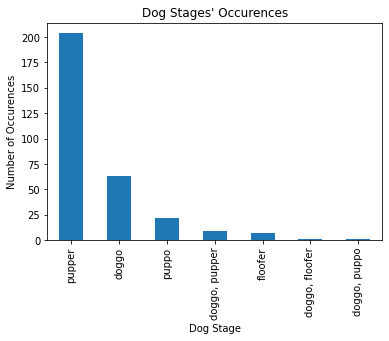

In [122]:
archive_clean.dog_stage.value_counts().plot(kind="bar")
plt.xlabel("Dog Stage")
plt.ylabel("Number of Occurences")
plt.title("Dog Stages' Occurences")

__Let's see the account activity during the week.__

In [123]:
archive_clean["day_name"]= archive_clean.timestamp.dt.day_name()

In [124]:
archive_clean.groupby("day_name")["tweet_id"].count()

day_name
Friday       283
Monday       327
Saturday     251
Sunday       256
Thursday     284
Tuesday      295
Wednesday    297
Name: tweet_id, dtype: int64

Text(0, 0.5, 'Day')

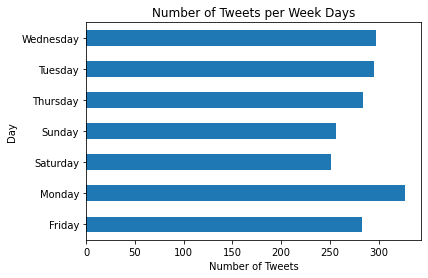

In [125]:
archive_clean.groupby("day_name")["tweet_id"].count().plot(kind="barh")
plt.title("Number of Tweets per Week Days")
plt.xlabel("Number of Tweets")
plt.ylabel("Day")

From the above, we can see that Monday has the highest number of tweets which is the begining of the week. Sat and Sun which are the weekend days have the lowest number of tweets.

What are the top 3 first predections for each dog stage?

In [126]:
archive_clean[archive_clean["dog_stage"]=="pupper"]["prediction1"].value_counts().nlargest(3)

golden_retriever    17
Pembroke            10
pug                  8
Name: prediction1, dtype: int64

In [127]:
archive_clean[archive_clean["dog_stage"]=="puppo"]["prediction1"].value_counts().nlargest(3)

Eskimo_dog            3
golden_retriever      2
Labrador_retriever    2
Name: prediction1, dtype: int64

In [128]:
archive_clean[archive_clean["dog_stage"]=="doggo"]["prediction3"].value_counts().nlargest(3)

Labrador_retriever             3
soft-coated_wheaten_terrier    2
Saluki                         2
Name: prediction3, dtype: int64

In [129]:
archive_clean[archive_clean["dog_stage"]=="floofer"]["prediction3"].value_counts().nlargest(3)

keeshond        2
Newfoundland    1
collie          1
Name: prediction3, dtype: int64

We can see that Labrador_retriever is a common prediction for all dog stages

__Which dog stage has the highest retweet number?__

In [130]:
archive_clean.groupby("dog_stage")["retweet_count"].sum()

dog_stage
doggo             381425.0
doggo, floofer      2887.0
doggo, pupper      31992.0
doggo, puppo       16552.0
floofer            28671.0
pupper            400093.0
puppo             120637.0
Name: retweet_count, dtype: float64

Text(0, 0.5, 'Number of retweets')

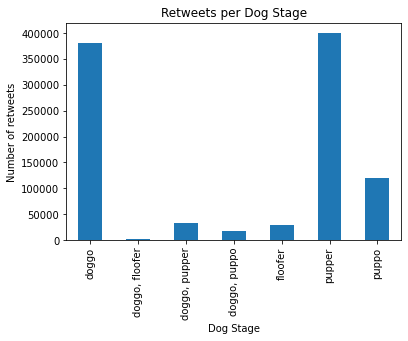

In [131]:
archive_clean.groupby("dog_stage")["retweet_count"].sum().plot(kind="bar")
plt.title("Retweets per Dog Stage")
plt.xlabel("Dog Stage")
plt.ylabel("Number of retweets")

__Which dog stage has the highest favorite number?__

In [132]:
archive_clean.groupby("dog_stage")["favorite_count"].sum()

dog_stage
doggo             1118246.0
doggo, floofer      15217.0
doggo, pupper      111029.0
doggo, puppo        42885.0
floofer             80494.0
pupper            1293147.0
puppo              441022.0
Name: favorite_count, dtype: float64

Text(0, 0.5, 'Number of Favorites')

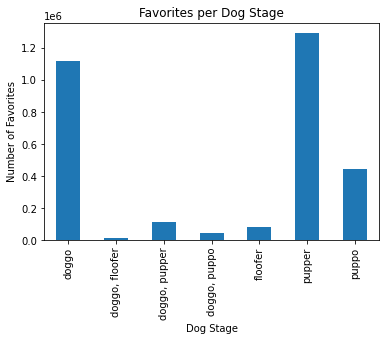

In [133]:
archive_clean.groupby("dog_stage")["favorite_count"].sum().plot(kind="bar")
plt.title("Favorites per Dog Stage")
plt.xlabel("Dog Stage")
plt.ylabel("Number of Favorites")